In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [6]:
import glob

# Paths - usando la estructura real
base_dir = "/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/rsds"

# Primero verificar qué archivos existen
print("🔍 Buscando archivos CMIP6 RSDS...")

paths = {}

# ACCESS-CM2
access_ssp245 = glob.glob(f"{base_dir}/ssp245/access_cm2/*.nc")
access_ssp370 = glob.glob(f"{base_dir}/ssp370/access_cm2/*.nc")
access_ssp585 = glob.glob(f"{base_dir}/ssp585/access_cm2/*.nc")

if access_ssp245 or access_ssp370 or access_ssp585:
    paths["ACCESS-CM2"] = {}
    if access_ssp245: 
        paths["ACCESS-CM2"]["ssp245"] = access_ssp245[0]
        print(f"✅ ACCESS-CM2 SSP245: {len(access_ssp245)} archivo(s)")
    if access_ssp370: 
        paths["ACCESS-CM2"]["ssp370"] = access_ssp370[0]
        print(f"✅ ACCESS-CM2 SSP370: {len(access_ssp370)} archivo(s)")
    if access_ssp585: 
        paths["ACCESS-CM2"]["ssp585"] = access_ssp585[0]
        print(f"✅ ACCESS-CM2 SSP585: {len(access_ssp585)} archivo(s)")

# GFDL-ESM4
gfdl_ssp245 = glob.glob(f"{base_dir}/ssp245/gfdl_esm4/*.nc")
gfdl_ssp370 = glob.glob(f"{base_dir}/ssp370/gfdl_esm4/*.nc")
gfdl_ssp585 = glob.glob(f"{base_dir}/ssp585/gfdl_esm4/*.nc")

if gfdl_ssp245 or gfdl_ssp370 or gfdl_ssp585:
    paths["GFDL-ESM4"] = {}
    if gfdl_ssp245: 
        paths["GFDL-ESM4"]["ssp245"] = gfdl_ssp245[0]
        print(f"✅ GFDL-ESM4 SSP245: {len(gfdl_ssp245)} archivo(s)")
    if gfdl_ssp370: 
        paths["GFDL-ESM4"]["ssp370"] = gfdl_ssp370[0]
        print(f"✅ GFDL-ESM4 SSP370: {len(gfdl_ssp370)} archivo(s)")
    if gfdl_ssp585: 
        paths["GFDL-ESM4"]["ssp585"] = gfdl_ssp585[0]
        print(f"✅ GFDL-ESM4 SSP585: {len(gfdl_ssp585)} archivo(s)")

print(f"\n📊 Total modelos encontrados: {len(paths)}")
print(f"📊 Total escenarios: {sum(len(v) for v in paths.values())}")

🔍 Buscando archivos CMIP6 RSDS...
✅ ACCESS-CM2 SSP245: 1 archivo(s)
✅ ACCESS-CM2 SSP370: 1 archivo(s)
✅ ACCESS-CM2 SSP585: 1 archivo(s)
✅ GFDL-ESM4 SSP245: 1 archivo(s)
✅ GFDL-ESM4 SSP370: 1 archivo(s)
✅ GFDL-ESM4 SSP585: 1 archivo(s)

📊 Total modelos encontrados: 2
📊 Total escenarios: 6


In [3]:
def area_weights(lat):
    return np.cos(np.deg2rad(lat))


In [4]:
def load_timeseries(path):
    ds = xr.open_dataset(path)
    da = ds["rsds"]

    # Pesos por latitud
    weights = area_weights(da.lat)
    da_weighted = da.weighted(weights)

    # Promedio global (lat, lon)
    ts = da_weighted.mean(("lat", "lon"))

    # Promedio anual
    ts_yearly = ts.groupby("time.year").mean()
    return ts_yearly


In [7]:
results = {}
for model, scenarios in paths.items():
    results[model] = {}
    for scen, path in scenarios.items():
        results[model][scen] = load_timeseries(path)


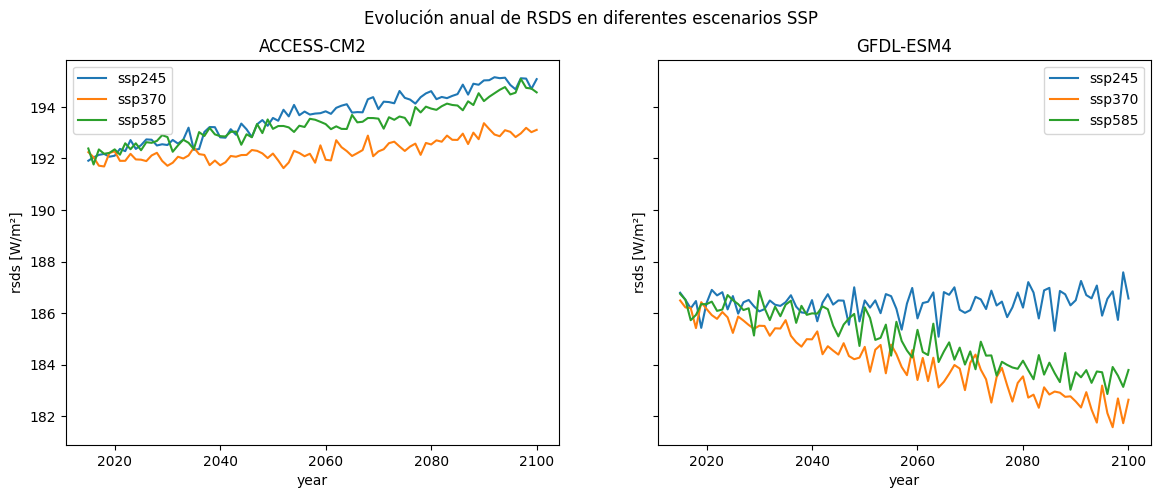

In [8]:
# Graficar
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

for i, model in enumerate(results):
    ax = axes[i]
    for scen, ts in results[model].items():
        ts.plot(ax=ax, label=scen)
    ax.set_title(model)
    ax.set_ylabel("rsds [W/m²]")
    ax.legend()

plt.suptitle("Evolución anual de RSDS en diferentes escenarios SSP")
plt.show()

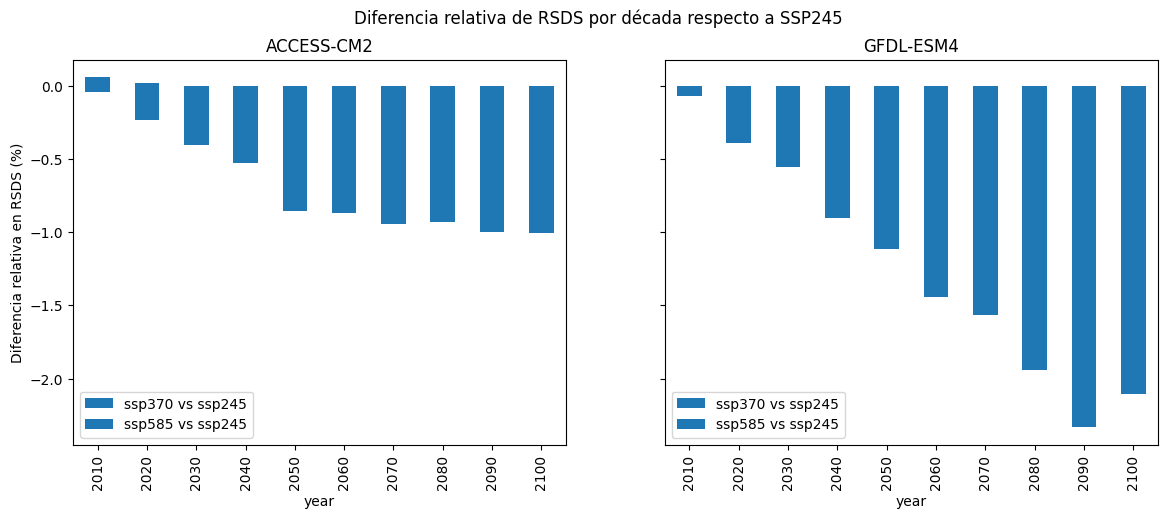

In [9]:
import matplotlib.pyplot as plt

# Función promedio por década
def decadal_means(ts):
    return ts.groupby((ts.year // 10) * 10).mean()

# Calcular
decadal = {}
for model, scenarios in results.items():
    decadal[model] = {}
    for scen, ts in scenarios.items():
        decadal[model][scen] = decadal_means(ts)

# Graficar diferencias relativas
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

for i, model in enumerate(decadal):
    ax = axes[i]
    ref = decadal[model]["ssp245"]
    for scen in ["ssp370", "ssp585"]:
        diff = (decadal[model][scen] - ref) / ref * 100
        diff.to_series().plot.bar(ax=ax, label=f"{scen} vs ssp245")
    ax.set_title(model)
    ax.set_ylabel("Diferencia relativa en RSDS (%)")
    ax.legend()

plt.suptitle("Diferencia relativa de RSDS por década respecto a SSP245")
plt.show()


## 📊 Análisis de Resultados - Modelos CMIP6 RSDS

### Hallazgos Clave:

**1. Comportamiento muy diferente entre modelos:**
- **ACCESS-CM2**: Muestra **aumento** de radiación solar hacia el futuro (~+2 W/m² para 2100)
  - SSP585 > SSP245 > SSP370
  - Tendencia creciente en todos los escenarios
  
- **GFDL-ESM4**: Muestra **disminución** de radiación solar hacia el futuro (~-4 W/m² para 2100)
  - SSP245 > SSP370 > SSP585 
  - Tendencia decreciente progresiva
  
**2. Implicaciones:**
- Los modelos tienen **sesgos opuestos** en proyecciones futuras
- Esto hace **crítico** el bias correction contra observaciones (GHI)
- La diferencia entre modelos puede ser del **3-4%** para 2100

**3. Próximos pasos:**
- Comparar estos datos contra observaciones GHI (2004-2014)
- Aplicar bias correction con Quantile Mapping
- Verificar si el QM realmente corrige estos sesgos